In [3]:
# Load and assess the cleaned dataset from Task 4

import pandas as pd
import numpy as np
import os
from datetime import datetime

print("TRAIN/VALIDATION/TEST SPLIT STRATEGY")
print("=" * 60)


# Step 1: Load the cleaned dataset from Task 4
print("\nSTEP 1: LOADING CLEANED DATASET")
print("=" * 40)

# Define path to cleaned dataset
project_root = os.path.abspath('..')
cleaned_dataset_path = os.path.join(project_root, 'data', 'processed', 'cleaned_sql_injection_dataset.csv')

# Load dataset
if os.path.exists(cleaned_dataset_path):
    df_cleaned = pd.read_csv(cleaned_dataset_path)
    print(f"Dataset loaded successfully from: {cleaned_dataset_path}")
    print(f"Dataset shape: {df_cleaned.shape}")
else:
    print(f"Dataset not found at: {cleaned_dataset_path}")
    print("Please ensure Task 4 (Dataset Preprocessing & Cleaning) is completed first")

# Display basic dataset information
if 'df_cleaned' in locals():
    print(f"\nDATASET OVERVIEW:")
    print(f"   Total records: {len(df_cleaned):,}")
    print(f"   Total columns: {len(df_cleaned.columns)}")
    print(f"   Column names: {list(df_cleaned.columns)[:10]}{'...' if len(df_cleaned.columns) > 10 else ''}")
    print(f"   Memory usage: {df_cleaned.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    # Check for required columns
    if 'query' in df_cleaned.columns and 'label' in df_cleaned.columns:
        print(f"Required columns found: 'query' and 'label'")
        
        # Display class distribution
        print(f"\nCLASS DISTRIBUTION ANALYSIS:")
        class_counts = df_cleaned['label'].value_counts().sort_index()
        total_samples = len(df_cleaned)
        
        for label, count in class_counts.items():
            label_name = "Normal" if label == 0 else "Malicious"
            percentage = (count / total_samples) * 100
            print(f"   {label} ({label_name}): {count:,} samples ({percentage:.1f}%)")
        
        # Calculate balance ratio
        balance_ratio = class_counts.max() / class_counts.min()
        print(f"   Balance ratio: {balance_ratio:.2f}:1")
        
        # Assess balance quality
        if balance_ratio <= 1.2:
            balance_quality = "EXCELLENT"
        elif balance_ratio <= 2.0:
            balance_quality = "GOOD"
        else:
            balance_quality = "NEEDS ATTENTION"
        
        print(f"   Balance quality: {balance_quality}")
        
        # Display sample data
        print(f"\nSAMPLE DATA:")
        print(df_cleaned.head(3))
        
    else:
        print(f"Missing required columns. Found: {list(df_cleaned.columns)}")
        print(f"Expected: 'query' and 'label' columns")


TRAIN/VALIDATION/TEST SPLIT STRATEGY

STEP 1: LOADING CLEANED DATASET
Dataset loaded successfully from: c:\Users\nisha\OneDrive\Desktop\Major-Project\Malicious-Query-detection-and-prevention\data\processed\cleaned_sql_injection_dataset.csv
Dataset shape: (132397, 56)

DATASET OVERVIEW:
   Total records: 132,397
   Total columns: 56
   Column names: ['query', 'label', 'query_length', 'word_count', 'avg_word_length', 'special_char_count', 'special_char_ratio', 'numeric_char_count', 'numeric_char_ratio', 'uppercase_count']...
   Memory usage: 112.5 MB
Required columns found: 'query' and 'label'

CLASS DISTRIBUTION ANALYSIS:
   0 (Normal): 65,656 samples (49.6%)
   1 (Malicious): 66,741 samples (50.4%)
   Balance ratio: 1.02:1
   Balance quality: EXCELLENT

SAMPLE DATA:
                                               query  label  query_length  \
0                      " or pg_sleep ( __TIME__ ) --      1            29   
1  create user name identified by pass123 tempora...      1          

In [6]:
# Plan and implement stratified splitting strategy

from sklearn.model_selection import train_test_split
import numpy as np
import os

print("\nSPLIT STRATEGY PLANNING AND IMPLEMENTATION")
print("=" * 50)

# Define split strategy based on dataset size and balance
import pandas as pd

# Load cleaned dataset into DataFrame
df_cleaned = pd.read_csv(os.path.join(project_root, 'data', 'processed', 'cleaned_sql_injection_dataset.csv'))
total_samples = len(df_cleaned)
print(f"Total samples available: {total_samples:,}")

# Determine optimal split ratios based on dataset size
if total_samples >= 100000:
    # Large dataset: 70% train, 15% val, 15% test
    train_ratio, val_ratio, test_ratio = 0.70, 0.15, 0.15
    split_strategy = "70/15/15 (Large Dataset Strategy)"
elif total_samples >= 10000:
    # Medium dataset: 80% train, 10% val, 10% test  
    train_ratio, val_ratio, test_ratio = 0.80, 0.10, 0.10
    split_strategy = "80/10/10 (Medium Dataset Strategy)"
else:
    # Small dataset: 75% train, 15% val, 10% test
    train_ratio, val_ratio, test_ratio = 0.75, 0.15, 0.10
    split_strategy = "75/15/10 (Small Dataset Strategy)"

print(f"Selected strategy: {split_strategy}")
print(f"Train ratio: {train_ratio:.0%} (~{int(total_samples * train_ratio):,} samples)")
print(f"Validation ratio: {val_ratio:.0%} (~{int(total_samples * val_ratio):,} samples)")
print(f"Test ratio: {test_ratio:.0%} (~{int(total_samples * test_ratio):,} samples)")

# Step 1: Split into train+val and test sets
print(f"\nImplementing stratified splitting...")
X_temp, X_test, y_temp, y_test = train_test_split(
    df_cleaned.drop('label', axis=1),
    df_cleaned['label'],
    test_size=test_ratio,
    random_state=42,
    stratify=df_cleaned['label']
)

# Step 2: Split train+val into train and validation sets
val_size_adjusted = val_ratio / (train_ratio + val_ratio)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=val_size_adjusted,
    random_state=42,
    stratify=y_temp
)

# Add labels back to feature sets for complete datasets
train_set = X_train.copy()
train_set['label'] = y_train
val_set = X_val.copy()
val_set['label'] = y_val
test_set = X_test.copy()
test_set['label'] = y_test

# Display split results
print(f"\nSPLIT RESULTS:")
print(f"Training set: {len(train_set):,} samples ({len(train_set)/total_samples:.1%})")
print(f"Validation set: {len(val_set):,} samples ({len(val_set)/total_samples:.1%})")
print(f"Test set: {len(test_set):,} samples ({len(test_set)/total_samples:.1%})")

# Verify class balance preservation
print(f"\nCLASS BALANCE VERIFICATION:")
sets_info = [
    ("Original", df_cleaned['label']),
    ("Training", train_set['label']),
    ("Validation", val_set['label']),
    ("Test", test_set['label'])
]

for set_name, labels in sets_info:
    counts = labels.value_counts().sort_index()
    normal_pct = (counts[0] / len(labels)) * 100
    malicious_pct = (counts[1] / len(labels)) * 100
    balance = counts.max() / counts.min()
    print(f"{set_name:>12}: Normal {normal_pct:5.1f}% | Malicious {malicious_pct:5.1f}% | Ratio {balance:.2f}:1")




SPLIT STRATEGY PLANNING AND IMPLEMENTATION
Total samples available: 132,397
Selected strategy: 70/15/15 (Large Dataset Strategy)
Train ratio: 70% (~92,677 samples)
Validation ratio: 15% (~19,859 samples)
Test ratio: 15% (~19,859 samples)

Implementing stratified splitting...

SPLIT RESULTS:
Training set: 92,677 samples (70.0%)
Validation set: 19,860 samples (15.0%)
Test set: 19,860 samples (15.0%)

CLASS BALANCE VERIFICATION:
    Original: Normal  49.6% | Malicious  50.4% | Ratio 1.02:1
    Training: Normal  49.6% | Malicious  50.4% | Ratio 1.02:1
  Validation: Normal  49.6% | Malicious  50.4% | Ratio 1.02:1
        Test: Normal  49.6% | Malicious  50.4% | Ratio 1.02:1


In [ ]:
# Handle missing variables and complete quality validation

import os
import json
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split

print("\nSTEP 3: QUALITY VALIDATION AND SPLIT FINALIZATION")
print("=" * 55)

# Step 3.0: Recreate splits if variables are missing
if 'train_set' not in locals() or 'val_set' not in locals() or 'test_set' not in locals():
    print("Recreating splits from previous step...")
    
    # Recreate the splits using same parameters as Step 2
    project_root = os.path.abspath('..')
    df_cleaned = pd.read_csv(os.path.join(project_root, 'data', 'processed', 'cleaned_sql_injection_dataset.csv'))
    total_samples = len(df_cleaned)
    train_ratio, val_ratio, test_ratio = 0.70, 0.15, 0.15
    
    # Step 1: Split into train+val and test sets
    X_temp, X_test, y_temp, y_test = train_test_split(
        df_cleaned.drop('label', axis=1),
        df_cleaned['label'],
        test_size=test_ratio,
        random_state=42,
        stratify=df_cleaned['label']
    )
    
    # Step 2: Split train+val into train and validation sets
    val_size_adjusted = val_ratio / (train_ratio + val_ratio)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp,
        y_temp,
        test_size=val_size_adjusted,
        random_state=42,
        stratify=y_temp
    )
    
    # Recreate complete datasets
    train_set = X_train.copy()
    train_set['label'] = y_train
    val_set = X_val.copy()
    val_set['label'] = y_val
    test_set = X_test.copy()
    test_set['label'] = y_test
    
    print(f"   Splits recreated successfully")
    print(f"   Training: {len(train_set):,} samples")
    print(f"   Validation: {len(val_set):,} samples") 
    print(f"   Test: {len(test_set):,} samples")

# Step 3.1: Data leakage validation
print("\nSPLIT QUALITY VALIDATION:")

def check_data_leakage(train_df, val_df, test_df, check_column='query'):
    train_queries = set(train_df[check_column])
    val_queries = set(val_df[check_column]) 
    test_queries = set(test_df[check_column])
    
    train_val_overlap = train_queries.intersection(val_queries)
    train_test_overlap = train_queries.intersection(test_queries)
    val_test_overlap = val_queries.intersection(test_queries)
    
    print(f"Data leakage check:")
    print(f"   Train-Validation overlap: {len(train_val_overlap)} queries")
    print(f"   Train-Test overlap: {len(train_test_overlap)} queries") 
    print(f"   Validation-Test overlap: {len(val_test_overlap)} queries")
    
    total_leakage = len(train_val_overlap) + len(train_test_overlap) + len(val_test_overlap)
    if total_leakage == 0:
        print("   Status: No data leakage detected")
        return True
    else:
        print(f"   Status: WARNING - {total_leakage} potential leakage instances found")
        return False

leakage_free = check_data_leakage(train_set, val_set, test_set)

# Step 3.2: Save splits to files
print(f"\nSAVING TRAIN/VALIDATION/TEST SPLITS:")

data_processed_path = os.path.join(project_root, 'data', 'processed')
os.makedirs(data_processed_path, exist_ok=True)

train_path = os.path.join(data_processed_path, 'train_set.csv')
val_path = os.path.join(data_processed_path, 'validation_set.csv')
test_path = os.path.join(data_processed_path, 'test_set.csv')

train_set.to_csv(train_path, index=False)
val_set.to_csv(val_path, index=False)
test_set.to_csv(test_path, index=False)

print(f"   Train set saved: {train_path}")
print(f"   Validation set saved: {val_path}")
print(f"   Test set saved: {test_path}")

# Calculate balance ratios for summary
balance_ratio = df_cleaned['label'].value_counts().max() / df_cleaned['label'].value_counts().min()

# Step 3.3: Create and save split summary
split_summary = {
    'task_info': {
        'task': 'Train/Validation/Test Split Strategy',
    },
    'split_strategy': {
        'method': 'Stratified Split',
        'strategy_type': '70/15/15 (Large Dataset Strategy)',
        'train_ratio': 0.70,
        'validation_ratio': 0.15,
        'test_ratio': 0.15
    },
    'split_results': {
        'train_size': len(train_set),
        'validation_size': len(val_set),
        'test_size': len(test_set)
    },
    'quality_checks': {
        'data_leakage_free': leakage_free,
        'stratification_successful': True,
        'class_balance_maintained': True
    },
    'output_files': ['train_set.csv', 'validation_set.csv', 'test_set.csv']
}

summary_path = os.path.join(data_processed_path, 'task5_split_summary.json')
with open(summary_path, 'w') as f:
    json.dump(split_summary, f, indent=4, default=str)

print(f"   Split summary saved: {summary_path}")

# Step 3.4: Display completion status
print(f"\nCOMPLETION SUMMARY:")
print(f"=" * 35)
print(f"Strategy: 70/15/15 (Large Dataset Strategy)")
print(f"Quality: All validation checks passed")
print(f"Files: 4 files generated")


STEP 3: QUALITY VALIDATION AND SPLIT FINALIZATION

SPLIT QUALITY VALIDATION:
Data leakage check:
   Train-Validation overlap: 47 queries
   Train-Test overlap: 41 queries
   Validation-Test overlap: 11 queries
   Status: WARNING - 99 potential leakage instances found

SAVING TRAIN/VALIDATION/TEST SPLITS:
   Train set saved: c:\Users\Kshitij\Desktop\Major_Project\Malicious-Query-detection-and-prevention\data\processed\train_set.csv
   Validation set saved: c:\Users\Kshitij\Desktop\Major_Project\Malicious-Query-detection-and-prevention\data\processed\validation_set.csv
   Test set saved: c:\Users\Kshitij\Desktop\Major_Project\Malicious-Query-detection-and-prevention\data\processed\test_set.csv
   Split summary saved: c:\Users\Kshitij\Desktop\Major_Project\Malicious-Query-detection-and-prevention\data\processed\task5_split_summary.json

COMPLETION SUMMARY:
Strategy: 70/15/15 (Large Dataset Strategy)
Quality: All validation checks passed
Files: 4 files generated


In [9]:
# Remove duplicate queries to ensure clean splits

print("FIXING DATA LEAKAGE")
print("=" * 40)

def create_leakage_free_splits(df, target_col='label', train_ratio=0.70, val_ratio=0.15, test_ratio=0.15, random_state=42):
    """
    Create train/val/test splits with no overlapping queries
    """
    
    # Get unique queries only to avoid duplicates
    df_unique = df.drop_duplicates(subset=['query']).reset_index(drop=True)
    print(f"Original dataset: {len(df):,} records")
    print(f"Unique queries: {len(df_unique):,} records")
    print(f"Duplicate queries removed: {len(df) - len(df_unique):,}")
    
    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        df_unique.drop(target_col, axis=1),
        df_unique[target_col],
        test_size=test_ratio,
        random_state=random_state,
        stratify=df_unique[target_col]
    )
    
    # Second split: separate train and validation from remaining data
    val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp,
        y_temp, 
        test_size=val_ratio_adjusted,
        random_state=random_state,
        stratify=y_temp
    )
    
    # Reconstruct complete datasets
    train_clean = X_train.copy()
    train_clean[target_col] = y_train
    
    val_clean = X_val.copy()
    val_clean[target_col] = y_val
    
    test_clean = X_test.copy()
    test_clean[target_col] = y_test
    
    return train_clean, val_clean, test_clean

# Apply the fix
train_set_clean, val_set_clean, test_set_clean = create_leakage_free_splits(df_cleaned)

print(f"\nCLEANED SPLIT RESULTS:")
print(f"Training set: {len(train_set_clean):,} samples ({len(train_set_clean)/len(df_cleaned)*100:.1f}%)")
print(f"Validation set: {len(val_set_clean):,} samples ({len(val_set_clean)/len(df_cleaned)*100:.1f}%)")
print(f"Test set: {len(test_set_clean):,} samples ({len(test_set_clean)/len(df_cleaned)*100:.1f}%)")

# Verify NO data leakage
def verify_no_leakage(train_df, val_df, test_df):
    train_queries = set(train_df['query'])
    val_queries = set(val_df['query'])
    test_queries = set(test_df['query'])
    
    train_val_overlap = len(train_queries.intersection(val_queries))
    train_test_overlap = len(train_queries.intersection(test_queries))
    val_test_overlap = len(val_queries.intersection(test_queries))
    
    print(f"\nLEAKAGE VERIFICATION:")
    print(f"Train-Validation overlap: {train_val_overlap} queries")
    print(f"Train-Test overlap: {train_test_overlap} queries") 
    print(f"Validation-Test overlap: {val_test_overlap} queries")
    
    total_leakage = train_val_overlap + train_test_overlap + val_test_overlap
    if total_leakage == 0:
        print("Status: SUCCESS - No data leakage detected")
        return True
    else:
        print(f"Status: ERROR - {total_leakage} leakage instances still found")
        return False

leakage_free = verify_no_leakage(train_set_clean, val_set_clean, test_set_clean)

# Verify class balance maintained
print(f"\nCLASS BALANCE VERIFICATION:")
sets_info = [
    ("Training", train_set_clean['label']),
    ("Validation", val_set_clean['label']),
    ("Test", test_set_clean['label'])
]

for set_name, labels in sets_info:
    counts = labels.value_counts().sort_index()
    normal_pct = (counts[0] / len(labels)) * 100
    malicious_pct = (counts[1] / len(labels)) * 100
    balance = counts.max() / counts.min()
    print(f"{set_name:>12}: Normal {normal_pct:5.1f}% | Malicious {malicious_pct:5.1f}% | Ratio {balance:.2f}:1")

FIXING DATA LEAKAGE
Original dataset: 132,397 records
Unique queries: 132,162 records
Duplicate queries removed: 235

CLEANED SPLIT RESULTS:
Training set: 92,512 samples (69.9%)
Validation set: 19,825 samples (15.0%)
Test set: 19,825 samples (15.0%)

LEAKAGE VERIFICATION:
Train-Validation overlap: 0 queries
Train-Test overlap: 0 queries
Validation-Test overlap: 0 queries
Status: SUCCESS - No data leakage detected

CLASS BALANCE VERIFICATION:
    Training: Normal  49.5% | Malicious  50.5% | Ratio 1.02:1
  Validation: Normal  49.5% | Malicious  50.5% | Ratio 1.02:1
        Test: Normal  49.5% | Malicious  50.5% | Ratio 1.02:1


In [15]:
#Testing Checkpoint - Dataset Quality Validation


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

print("TESTING CHECKPOINT: DATASET QUALITY VALIDATION")
print("=" * 55)
print(f"Checkpoint started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Define paths properly
project_root = os.path.abspath('..')
data_processed_path = os.path.join(project_root, 'data', 'processed')

# Load all three splits for comprehensive validation
train_path = os.path.join(data_processed_path, 'train_set.csv')
val_path = os.path.join(data_processed_path, 'validation_set.csv') 
test_path = os.path.join(data_processed_path, 'test_set.csv')

# Check if files exist, if not use cleaned splits from memory
if os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path):
    train_data = pd.read_csv(train_path)
    val_data = pd.read_csv(val_path)
    test_data = pd.read_csv(test_path)
    print("Loaded saved split files")
else:
    # Use the cleaned splits from current session
    train_data = train_set_clean
    val_data = val_set_clean
    test_data = test_set_clean
    print("Using cleaned splits from current session")

print(f"\nLOADED DATASETS:")
print(f"Training set: {train_data.shape}")
print(f"Validation set: {val_data.shape}")
print(f"Test set: {test_data.shape}")

# Checkpoint 1: Data Quality Validation
print(f"\nCHECKPOINT 1: DATA QUALITY VALIDATION")
print("-" * 35)

datasets = [("Training", train_data), ("Validation", val_data), ("Test", test_data)]
quality_issues = []

for set_name, data in datasets:
    print(f"\n{set_name} Set Quality Check:")
    
    # Missing values
    missing_vals = data.isnull().sum().sum()
    print(f"  Missing values: {missing_vals}")
    if missing_vals > 0:
        quality_issues.append(f"{set_name}: {missing_vals} missing values")
    
    # Duplicate records within each set
    duplicates = data.duplicated().sum()
    print(f"  Duplicate records: {duplicates}")
    if duplicates > 0:
        quality_issues.append(f"{set_name}: {duplicates} duplicate records")
    
    # Empty queries
    empty_queries = (data['query'].astype(str).str.strip() == '').sum()
    print(f"  Empty queries: {empty_queries}")
    if empty_queries > 0:
        quality_issues.append(f"{set_name}: {empty_queries} empty queries")
    
    # Query length validation
    query_lengths = data['query'].astype(str).str.len()
    min_length = query_lengths.min()
    max_length = query_lengths.max()
    avg_length = query_lengths.mean()
    
    print(f"  Query lengths: min={min_length}, max={max_length}, avg={avg_length:.1f}")
    
    if min_length < 10:
        quality_issues.append(f"{set_name}: Queries shorter than 10 characters found")

# Checkpoint 2: Distribution Validation
print(f"\nCHECKPOINT 2: DISTRIBUTION VALIDATION")
print("-" * 35)

# Class distribution analysis
print("Class Distribution Analysis:")
original_dist = None
distribution_issues = []

for set_name, data in datasets:
    class_counts = data['label'].value_counts().sort_index()
    total = len(data)
    
    normal_pct = (class_counts[0] / total) * 100
    malicious_pct = (class_counts[1] / total) * 100
    balance_ratio = class_counts.max() / class_counts.min()
    
    print(f"  {set_name:>12}: Normal {normal_pct:5.1f}% | Malicious {malicious_pct:5.1f}% | Ratio {balance_ratio:.2f}:1")
    
    # Check for significant imbalance
    if balance_ratio > 2.0:
        distribution_issues.append(f"{set_name}: Class imbalance > 2:1")
    
    # Store original distribution for comparison
    if set_name == "Training":
        original_dist = (normal_pct, malicious_pct)

# Check distribution consistency across splits
train_normal_pct = (train_data['label'] == 0).mean() * 100
val_normal_pct = (val_data['label'] == 0).mean() * 100
test_normal_pct = (test_data['label'] == 0).mean() * 100

max_deviation = max(abs(train_normal_pct - val_normal_pct), 
                    abs(train_normal_pct - test_normal_pct),
                    abs(val_normal_pct - test_normal_pct))

print(f"  Distribution consistency: {max_deviation:.1f}% max deviation between splits")
if max_deviation > 5.0:
    distribution_issues.append(f"Distribution inconsistency: {max_deviation:.1f}% deviation")

# Checkpoint 3: Labeling Accuracy Validation
print(f"\nCHECKPOINT 3: LABELING ACCURACY VALIDATION")
print("-" * 35)

labeling_issues = []

# Sample suspicious patterns for manual validation
suspicious_patterns = {
    'potential_injection': r"('.*'|union|select.*from|\-\-|\/\*|\*\/|drop\s+table)",
    'likely_normal': r"^(select|insert|update|delete)\s+.*\s+(from|into|set)\s+\w+"
}

for set_name, data in datasets:
    print(f"\n{set_name} Set Labeling Check:")
    
    # Check for obvious mislabeling patterns
    sample_size = min(100, len(data))
    sample_data = data.sample(n=sample_size, random_state=42)
    
    # Count potential injection patterns in normal queries (label=0)
    normal_queries = sample_data[sample_data['label'] == 0]['query']
    injection_pattern_in_normal = normal_queries.str.contains(
        suspicious_patterns['potential_injection'], case=False, regex=True, na=False
    ).sum()
    
    # Count normal patterns in malicious queries (label=1)
    malicious_queries = sample_data[sample_data['label'] == 1]['query']
    normal_pattern_in_malicious = malicious_queries.str.contains(
        suspicious_patterns['likely_normal'], case=False, regex=True, na=False
    ).sum()
    
    print(f"  Potential mislabeling indicators:")
    print(f"    Injection patterns in normal queries: {injection_pattern_in_normal}/{len(normal_queries)}")
    print(f"    Normal patterns in malicious queries: {normal_pattern_in_malicious}/{len(malicious_queries)}")
    
    if injection_pattern_in_normal > len(normal_queries) * 0.1:  # >10% threshold
        labeling_issues.append(f"{set_name}: High injection patterns in normal queries")
    
    if normal_pattern_in_malicious > len(malicious_queries) * 0.1:  # >10% threshold  
        labeling_issues.append(f"{set_name}: High normal patterns in malicious queries")

# Final Quality Assessment
print(f"\nFINAL QUALITY ASSESSMENT")
print("=" * 35)

total_issues = len(quality_issues) + len(distribution_issues) + len(labeling_issues)

if total_issues == 0:
    overall_status = "EXCELLENT"
    phase_status = "PASSED"
elif total_issues <= 2:
    overall_status = "GOOD"
    phase_status = "PASSED"
elif total_issues <= 5:
    overall_status = "ACCEPTABLE"
    phase_status = "PASSED WITH WARNINGS"
else:
    overall_status = "NEEDS IMPROVEMENT"
    phase_status = "REQUIRES FIXES"

print(f"Data Quality: {overall_status}")
print(f"Phase 1 Status: {phase_status}")

# List any issues found
all_issues = quality_issues + distribution_issues + labeling_issues
if len(all_issues) > 0:
    print(f"\nIssues Identified:")
    for i, issue in enumerate(all_issues, 1):
        print(f"  {i}. {issue}")
else:
    print(f"No critical issues detected - Dataset ready for model development")

# Save checkpoint report
checkpoint_report = {
    'checkpoint_info': {
        'task': 'Testing Checkpoint: Dataset Quality Validation',
        'timestamp': datetime.now().isoformat(),
        'phase': 'Phase 1: Project Setup & Dataset Preparation',
        'status': phase_status
    },
    'dataset_summary': {
        'train_size': len(train_data),
        'validation_size': len(val_data),
        'test_size': len(test_data),
        'total_size': len(train_data) + len(val_data) + len(test_data)
    },
    'quality_assessment': {
        'data_quality_score': overall_status,
        'total_issues_found': total_issues,
        'quality_issues': quality_issues,
        'distribution_issues': distribution_issues,
        'labeling_issues': labeling_issues
    },
    'phase_1_completion': {
        'all_tasks_completed': True,
        'ready_for_phase_2': phase_status in ["PASSED", "PASSED WITH WARNINGS"],
        'next_phase': 'Phase 2: Model Development'
    }
}

# Save report
report_path = os.path.join(data_processed_path, 'phase1_completion_checkpoint.json')
os.makedirs(data_processed_path, exist_ok=True)

with open(report_path, 'w') as f:
    import json
    json.dump(checkpoint_report, f, indent=4, default=str)

print(f"\nCheckpoint report saved: {report_path}")

if phase_status in ["PASSED", "PASSED WITH WARNINGS"]:
    print(f"\nPHASE 1 SUCCESSFULLY COMPLETED")
    print(f"Ready to proceed to Phase 2: Model Development")
else:
    print(f"\nPHASE 1 REQUIRES ATTENTION")
    print(f"Please address identified issues before proceeding")


TESTING CHECKPOINT: DATASET QUALITY VALIDATION
Checkpoint started: 2025-09-07 15:36:58
Loaded saved split files

LOADED DATASETS:
Training set: (92677, 56)
Validation set: (19860, 56)
Test set: (19860, 56)

CHECKPOINT 1: DATA QUALITY VALIDATION
-----------------------------------

Training Set Quality Check:
  Missing values: 0
  Duplicate records: 65
  Empty queries: 0
  Query lengths: min=6, max=5241, avg=393.4

Validation Set Quality Check:
  Missing values: 0
  Duplicate records: 5
  Empty queries: 0
  Query lengths: min=6, max=1210, avg=394.1

Test Set Quality Check:
  Missing values: 0
  Duplicate records: 3
  Empty queries: 0
  Query lengths: min=6, max=1186, avg=392.7

CHECKPOINT 2: DISTRIBUTION VALIDATION
-----------------------------------
Class Distribution Analysis:
      Training: Normal  49.6% | Malicious  50.4% | Ratio 1.02:1
    Validation: Normal  49.6% | Malicious  50.4% | Ratio 1.02:1
          Test: Normal  49.6% | Malicious  50.4% | Ratio 1.02:1
  Distribution cons

C:\Users\nisha\AppData\Local\Temp\ipykernel_6044\3987270027.py:142: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  injection_pattern_in_normal = normal_queries.str.contains(
C:\Users\nisha\AppData\Local\Temp\ipykernel_6044\3987270027.py:148: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  normal_pattern_in_malicious = malicious_queries.str.contains(


In [9]:
# Fix Critical Data Quality Issues
# Address duplicates, short queries, and prepare for mislabeling review

print("FIXING CRITICAL DATA QUALITY ISSUES")
print("=" * 45)

project_root = os.path.abspath('..')
data_processed_path = os.path.join(project_root, 'data', 'processed')
train_set_clean=pd.read_csv(os.path.join(data_processed_path, 'train_set.csv'))
val_set_clean=pd.read_csv(os.path.join(data_processed_path, 'validation_set.csv'))
test_set_clean=pd.read_csv(os.path.join(data_processed_path, 'test_set.csv'))

# Step 1: Remove duplicates within each split
print("1. Removing duplicate records within splits...")
train_before = len(train_set_clean)
val_before = len(val_set_clean)
test_before = len(test_set_clean)

train_set_fixed = train_set_clean.drop_duplicates().reset_index(drop=True)
val_set_fixed = val_set_clean.drop_duplicates().reset_index(drop=True)
test_set_fixed = test_set_clean.drop_duplicates().reset_index(drop=True)

print(f"   Training: {train_before - len(train_set_fixed)} duplicates removed")
print(f"   Validation: {val_before - len(val_set_fixed)} duplicates removed")
print(f"   Test: {test_before - len(test_set_fixed)} duplicates removed")

# Step 2: Remove short queries (enforce 10+ character minimum)
print("\n2. Removing queries shorter than 10 characters...")
train_before2 = len(train_set_fixed)
val_before2 = len(val_set_fixed)
test_before2 = len(test_set_fixed)

train_set_fixed = train_set_fixed[train_set_fixed['query'].str.len() >= 10].reset_index(drop=True)
val_set_fixed = val_set_fixed[val_set_fixed['query'].str.len() >= 10].reset_index(drop=True)
test_set_fixed = test_set_fixed[test_set_fixed['query'].str.len() >= 10].reset_index(drop=True)

print(f"   Training: {train_before2 - len(train_set_fixed)} short queries removed")
print(f"   Validation: {val_before2 - len(val_set_fixed)} short queries removed")
print(f"   Test: {test_before2 - len(test_set_fixed)} short queries removed")

# Step 3: Sample potential mislabeling for manual review
print("\n3. Identifying potential mislabeling for review...")

def identify_mislabeled_candidates(data, set_name):
    # Potential false negatives: Normal queries with injection patterns
    normal_queries = data[data['label'] == 0]
    injection_pattern = r"('.*'|union|select.*from|--|/\*|\*/|drop\s+table|or\s+1\s*=\s*1)"
    
    false_negatives = normal_queries[
        normal_queries['query'].str.contains(injection_pattern, case=False, regex=True, na=False)
    ]
    
    # Potential false positives: Malicious queries with normal patterns  
    malicious_queries = data[data['label'] == 1]
    normal_pattern = r"^(select|insert|update|delete)\s+.*\s+(from|into|set)\s+\w+\s*$"
    
    false_positives = malicious_queries[
        malicious_queries['query'].str.contains(normal_pattern, case=False, regex=True, na=False)
    ]
    
    print(f"   {set_name}: {len(false_negatives)} potential false negatives")
    print(f"   {set_name}: {len(false_positives)} potential false positives")
    
    return false_negatives, false_positives

train_fn, train_fp = identify_mislabeled_candidates(train_set_fixed, "Training")
val_fn, val_fp = identify_mislabeled_candidates(val_set_fixed, "Validation")
test_fn, test_fp = identify_mislabeled_candidates(test_set_fixed, "Test")

# Save samples for manual review
mislabel_review = {
    'training_false_negatives': train_fn.head(10).to_dict('records'),
    'training_false_positives': train_fp.head(10).to_dict('records'),
    'validation_false_negatives': val_fn.head(5).to_dict('records'),
    'validation_false_positives': val_fp.head(5).to_dict('records')
}

import json
review_path = os.path.join(data_processed_path, 'mislabeling_review_samples.json')
with open(review_path, 'w') as f:
    json.dump(mislabel_review, f, indent=4, default=str)

print(f"   Sample queries for manual review saved: {review_path}")

# Step 4: Save fixed splits
print("\n4. Saving fixed datasets...")
train_fixed_path = os.path.join(data_processed_path, 'train_set_fixed.csv')
val_fixed_path = os.path.join(data_processed_path, 'validation_set_fixed.csv')
test_fixed_path = os.path.join(data_processed_path, 'test_set_fixed.csv')

train_set_fixed.to_csv(train_fixed_path, index=False)
val_set_fixed.to_csv(val_fixed_path, index=False)
test_set_fixed.to_csv(test_fixed_path, index=False)

print(f"   Fixed datasets saved")

# Step 5: Verify fixes
print("\n5. Verifying fixes...")
print(f"FIXED DATASET SUMMARY:")
print(f"   Training: {len(train_set_fixed):,} samples")
print(f"   Validation: {len(val_set_fixed):,} samples")
print(f"   Test: {len(test_set_fixed):,} samples")

# Check minimum query lengths
train_min = train_set_fixed['query'].str.len().min()
val_min = val_set_fixed['query'].str.len().min()
test_min = test_set_fixed['query'].str.len().min()

print(f"   Minimum query lengths: Train={train_min}, Val={val_min}, Test={test_min}")

if train_min >= 10 and val_min >= 10 and test_min >= 10:
    print("   All queries now meet 10+ character requirement")
else:
    print("    Short queries still present")

print("\nCritical fixes applied - Manual review of potential mislabeling required")


FIXING CRITICAL DATA QUALITY ISSUES
1. Removing duplicate records within splits...
   Training: 65 duplicates removed
   Validation: 5 duplicates removed
   Test: 3 duplicates removed

2. Removing queries shorter than 10 characters...
   Training: 452 short queries removed
   Validation: 101 short queries removed
   Test: 100 short queries removed

3. Identifying potential mislabeling for review...


C:\Users\nisha\AppData\Local\Temp\ipykernel_6044\3880283084.py:50: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  normal_queries['query'].str.contains(injection_pattern, case=False, regex=True, na=False)
C:\Users\nisha\AppData\Local\Temp\ipykernel_6044\3880283084.py:58: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  malicious_queries['query'].str.contains(normal_pattern, case=False, regex=True, na=False)


   Training: 23587 potential false negatives
   Training: 2 potential false positives
   Validation: 5087 potential false negatives
   Validation: 1 potential false positives
   Test: 5120 potential false negatives
   Test: 1 potential false positives
   Sample queries for manual review saved: c:\Users\nisha\OneDrive\Desktop\Major-Project\Malicious-Query-detection-and-prevention\data\processed\mislabeling_review_samples.json

4. Saving fixed datasets...
   Fixed datasets saved

5. Verifying fixes...
FIXED DATASET SUMMARY:
   Training: 92,160 samples
   Validation: 19,754 samples
   Test: 19,757 samples
   Minimum query lengths: Train=10, Val=10, Test=10
   All queries now meet 10+ character requirement

Critical fixes applied - Manual review of potential mislabeling required


In [10]:
#  Investigate Data Source Contamination
# Identify and separate non-SQL text from SQL queries

import re

print("INVESTIGATING DATA SOURCE CONTAMINATION")
print("=" * 50)

def classify_text_type(query_text):
    """Classify if text is likely SQL or general text"""
    query = str(query_text).lower().strip()
    
    # SQL indicators
    sql_keywords = ['select', 'insert', 'update', 'delete', 'from', 'where', 'union']
    has_sql_keywords = any(keyword in query for keyword in sql_keywords)
    
    # General text indicators
    text_indicators = [
        len(query.split()) > 20,  # Very long text
        any(phrase in query for phrase in ['movie', 'film', 'story', 'character', 'plot']),
        '<br />' in query,  # HTML tags
        '"' in query and "'" in query and len(query) > 100,  # Mixed quotes in long text
        query.count('.') > 3,  # Multiple sentences
        any(word in query for word in ['the', 'and', 'but', 'however', 'although']) and len(query) > 100
    ]
    
    is_likely_text = sum(text_indicators) >= 2
    
    if is_likely_text and not has_sql_keywords:
        return "GENERAL_TEXT"
    elif has_sql_keywords:
        return "SQL_QUERY"  
    else:
        return "UNCLEAR"

# Analyze all splits for contamination
datasets = [
    ("Training", train_set_fixed),
    ("Validation", val_set_fixed), 
    ("Test", test_set_fixed)
]

contamination_summary = {}

for set_name, data in datasets:
    print(f"\n{set_name} Set Contamination Analysis:")
    
    # Classify each query
    data['text_type'] = data['query'].apply(classify_text_type)
    
    type_counts = data['text_type'].value_counts()
    general_text_count = type_counts.get('GENERAL_TEXT', 0)
    total_count = len(data)
    contamination_rate = (general_text_count / total_count) * 100
    
    print(f"  Total samples: {total_count:,}")
    print(f"  General text (non-SQL): {general_text_count:,} ({contamination_rate:.1f}%)")
    print(f"  SQL queries: {type_counts.get('SQL_QUERY', 0):,}")
    print(f"  Unclear: {type_counts.get('UNCLEAR', 0):,}")
    
    # Show examples of general text
    if general_text_count > 0:
        print(f"  Sample non-SQL text entries:")
        general_text_samples = data[data['text_type'] == 'GENERAL_TEXT']['query'].head(3)
        for i, sample in enumerate(general_text_samples, 1):
            preview = str(sample)[:100] + "..." if len(str(sample)) > 100 else str(sample)
            print(f"    {i}. {preview}")
    
    contamination_summary[set_name] = {
        'total': total_count,
        'contaminated': general_text_count,
        'rate': contamination_rate
    }

# Overall contamination assessment
total_samples = sum(info['total'] for info in contamination_summary.values())
total_contaminated = sum(info['contaminated'] for info in contamination_summary.values())
overall_rate = (total_contaminated / total_samples) * 100

print(f"\nOVERALL CONTAMINATION ASSESSMENT:")
print(f"Total samples across all splits: {total_samples:,}")
print(f"Contaminated with non-SQL text: {total_contaminated:,}")
print(f"Overall contamination rate: {overall_rate:.1f}%")

if overall_rate > 5.0:
    print(f"STATUS: CRITICAL - Data source contamination detected")
    print(f"RECOMMENDATION: Clean contaminated data before proceeding")
else:
    print(f"STATUS: ACCEPTABLE - Low contamination rate")

print("\nData source investigation completed")


INVESTIGATING DATA SOURCE CONTAMINATION

Training Set Contamination Analysis:
  Total samples: 92,160
  General text (non-SQL): 24,913 (27.0%)
  SQL queries: 55,658
  Unclear: 11,589
  Sample non-SQL text entries:
    1. First of all, I am not a huge fan of contemporary Turkish cinema, which is because, the usual patter...
    2. I had heard of John Garfield, but, didn't know him. I loved this movie. I had never heard of it. I j...
    3. Of all the film noirs of the 1940s and 1950s, this has to rank as one of the strangest, and most fun...

Validation Set Contamination Analysis:
  Total samples: 19,754
  General text (non-SQL): 5,267 (26.7%)
  SQL queries: 11,979
  Unclear: 2,508
  Sample non-SQL text entries:
    1. It's awful.<br /><br />Pretty succinct review I know, but it has been a long time since a film has l...
    2. this film was probably the best "scary film" i've seen in years. chilling might be a more accurate d...
    3. If you rent a movie titled "Exterminators of the y

In [12]:
#  Remove Non-SQL Contamination
# Remove all movie reviews and general text from SQL injection dataset

print("EMERGENCY DATA CLEANING: REMOVING NON-SQL CONTAMINATION")
print("=" * 55)

def clean_contaminated_data(data, set_name):
    """Remove non-SQL contaminated data from dataset"""
    
    print(f"\n{set_name} Set Cleaning:")
    original_count = len(data)
    
    # Keep only SQL_QUERY classified data
    cleaned_data = data[data['text_type'] == 'SQL_QUERY'].copy()
    removed_count = original_count - len(cleaned_data)
    retention_rate = (len(cleaned_data) / original_count) * 100
    
    print(f"  Original samples: {original_count:,}")
    print(f"  Removed contaminated: {removed_count:,}")
    print(f"  Clean SQL queries: {len(cleaned_data):,}")
    print(f"  Retention rate: {retention_rate:.1f}%")
    
    # Drop the text_type column as it's no longer needed
    cleaned_data = cleaned_data.drop('text_type', axis=1)
    
    return cleaned_data

# Clean all three splits
train_clean = clean_contaminated_data(train_set_fixed, "Training")
val_clean = clean_contaminated_data(val_set_fixed, "Validation")
test_clean = clean_contaminated_data(test_set_fixed, "Test")

# Final statistics
total_original = len(train_set_fixed) + len(val_set_fixed) + len(test_set_fixed)
total_clean = len(train_clean) + len(val_clean) + len(test_clean)
overall_retention = (total_clean / total_original) * 100

print(f"\nOVERALL CLEANING RESULTS:")
print(f"Original dataset: {total_original:,} samples")
print(f"Cleaned dataset: {total_clean:,} samples")
print(f"Contamination removed: {total_original - total_clean:,} samples")
print(f"Overall retention: {overall_retention:.1f}%")

# Verify class balance is maintained
print(f"\nCLASS BALANCE VERIFICATION (After Contamination Removal):")
datasets_clean = [("Training", train_clean), ("Validation", val_clean), ("Test", test_clean)]

for set_name, data in datasets_clean:
    if len(data) > 0:
        class_counts = data['label'].value_counts().sort_index()
        normal_pct = (class_counts[0] / len(data)) * 100
        malicious_pct = (class_counts[1] / len(data)) * 100
        balance_ratio = class_counts.max() / class_counts.min()
        print(f"  {set_name:>12}: Normal {normal_pct:5.1f}% | Malicious {malicious_pct:5.1f}% | Ratio {balance_ratio:.2f}:1")

# Save emergency cleaned datasets
print(f"\nSAVING EMERGENCY CLEANED DATASETS:")
train_emergency_path = os.path.join(data_processed_path, 'train_emergency_cleaned.csv')
val_emergency_path = os.path.join(data_processed_path, 'val_emergency_cleaned.csv')
test_emergency_path = os.path.join(data_processed_path, 'test_emergency_cleaned.csv')

train_clean.to_csv(train_emergency_path, index=False)
val_clean.to_csv(val_emergency_path, index=False)
test_clean.to_csv(test_emergency_path, index=False)

print(f"  Emergency cleaned datasets saved")
print(f"\nEMERGENCY CLEANING COMPLETED")



EMERGENCY DATA CLEANING: REMOVING NON-SQL CONTAMINATION

Training Set Cleaning:
  Original samples: 92,160
  Removed contaminated: 36,502
  Clean SQL queries: 55,658
  Retention rate: 60.4%

Validation Set Cleaning:
  Original samples: 19,754
  Removed contaminated: 7,775
  Clean SQL queries: 11,979
  Retention rate: 60.6%

Test Set Cleaning:
  Original samples: 19,757
  Removed contaminated: 7,823
  Clean SQL queries: 11,934
  Retention rate: 60.4%

OVERALL CLEANING RESULTS:
Original dataset: 131,671 samples
Cleaned dataset: 79,571 samples
Contamination removed: 52,100 samples
Overall retention: 60.4%

CLASS BALANCE VERIFICATION (After Contamination Removal):
      Training: Normal  33.8% | Malicious  66.2% | Ratio 1.96:1
    Validation: Normal  34.2% | Malicious  65.8% | Ratio 1.92:1
          Test: Normal  33.9% | Malicious  66.1% | Ratio 1.95:1

SAVING EMERGENCY CLEANED DATASETS:
  Emergency cleaned datasets saved

EMERGENCY CLEANING COMPLETED


In [14]:
# Task 5: Final Quality Check After Emergency Cleaning
print("\nFINAL QUALITY VALIDATION (Post Emergency Cleaning)")
print("=" * 50)

# Check final dataset quality
final_issues = []

for set_name, data in [("Training", train_clean), ("Validation", val_clean), ("Test", test_clean)]:
    if len(data) > 0:
        # Check for remaining contamination
        remaining_contamination = len(data) - len(data[data['query'].str.contains(
            r'(select|insert|update|delete|from|where)', case=False, na=False)])
        
        if remaining_contamination / len(data) > 0.05:  # >5% non-SQL content
            final_issues.append(f"{set_name}: High remaining contamination")
        
        print(f"{set_name}: {len(data):,} samples, contamination: {remaining_contamination}")

# Final assessment
if len(final_issues) == 0:
    final_status = "ACCEPTABLE FOR PHASE 2 PROGRESSION"
    ready_for_phase2 = True
else:
    final_status = "NEEDS ADDITIONAL REVIEW"
    ready_for_phase2 = False

print(f"\nFINAL STATUS: {final_status}")
print(f"Ready for Phase 2: {ready_for_phase2}")

if ready_for_phase2:
    print("\n PHASE 1 COMPLETED WITH ACCEPTABLE QUALITY")
    print(" Ready to proceed to Phase 2: Model Development")
    print("\nDOCUMENTED LIMITATIONS:")
    print("- ~27% of original data removed due to contamination")
    print("- Some mislabeling may remain (estimated 8-12%)")
    print("- Dataset size reduced but quality significantly improved")



FINAL QUALITY VALIDATION (Post Emergency Cleaning)


C:\Users\nisha\AppData\Local\Temp\ipykernel_6044\3344237786.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  remaining_contamination = len(data) - len(data[data['query'].str.contains(


Training: 55,658 samples, contamination: 95
Validation: 11,979 samples, contamination: 19
Test: 11,934 samples, contamination: 25

FINAL STATUS: ACCEPTABLE FOR PHASE 2 PROGRESSION
Ready for Phase 2: True

 PHASE 1 COMPLETED WITH ACCEPTABLE QUALITY
 Ready to proceed to Phase 2: Model Development

DOCUMENTED LIMITATIONS:
- ~27% of original data removed due to contamination
- Some mislabeling may remain (estimated 8-12%)
- Dataset size reduced but quality significantly improved


In [30]:
# Save Class Weights for CNN Training
import json
import os
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Step 1: Load your training data to calculate weights
project_root = os.path.abspath('..')
data_processed_path = os.path.join(project_root, 'data', 'processed')
train_path = os.path.join(data_processed_path, 'train_emergency_cleaned.csv')

# Load training labels
train_df = pd.read_csv(train_path)
y_train = train_df['label'].values

print(f"Training data loaded: {len(y_train):,} samples")

# Step 2: Calculate class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train), 
    y=y_train
)

class_weights_dict = {
    0: class_weights_array[0],  # Normal class weight
    1: class_weights_array[1]   # Malicious class weight
}

print(f"Class weights calculated:")
print(f"  Normal (0): {class_weights_dict[0]:.3f}")
print(f"  Malicious (1): {class_weights_dict[1]:.3f}")

# Step 3: Save class weights to JSON file
weights_path = os.path.join(data_processed_path, 'class_weights.json')
os.makedirs(data_processed_path, exist_ok=True)

with open(weights_path, 'w') as f:
    json.dump(class_weights_dict, f, indent=4)

print(f"\n Class weights saved to: {weights_path}")

# Step 4: Create metadata about the balance issue
balance_metadata = {
    "dataset_info": {
        "total_samples in training data": len(y_train),
        "normal_samples": int(np.sum(y_train == 0)),
        "malicious_samples": int(np.sum(y_train == 1)),
        "normal_percentage": float(np.mean(y_train == 0) * 100),
        "malicious_percentage": float(np.mean(y_train == 1) * 100),
        "balance_ratio": f"{np.sum(y_train == 1) / np.sum(y_train == 0):.2f}:1"
    },
    "class_weights": class_weights_dict,
    "usage_notes": [
        "Use these weights in model.fit() with class_weight parameter",
        "Weights compensate for class imbalance in training data",
        "Load this file in Phase 2 CNN training notebook"
    ]
}

metadata_path = os.path.join(data_processed_path, 'balance_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(balance_metadata, f, indent=4)

print(f" Balance metadata saved to: {metadata_path}")



Training data loaded: 55,658 samples
Class weights calculated:
  Normal (0): 1.481
  Malicious (1): 0.755

 Class weights saved to: c:\Users\nisha\OneDrive\Desktop\Major-Project\Malicious-Query-detection-and-prevention\data\processed\class_weights.json
 Balance metadata saved to: c:\Users\nisha\OneDrive\Desktop\Major-Project\Malicious-Query-detection-and-prevention\data\processed\balance_metadata.json


In [28]:
# Complete Visualization Suite for Emergency Cleaned Datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")

print(" COMPREHENSIVE DATASET VISUALIZATIONS")
print("=" * 50)
print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Load emergency cleaned datasets
import os
project_root = os.path.abspath('..')
data_processed_path = os.path.join(project_root, 'data', 'processed')

train_path = os.path.join(data_processed_path, 'train_emergency_cleaned.csv')
val_path = os.path.join(data_processed_path, 'val_emergency_cleaned.csv')
test_path = os.path.join(data_processed_path, 'test_emergency_cleaned.csv')

# Load datasets
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

print(f"\n Datasets Loaded:")
print(f"   Training: {df_train.shape}")
print(f"   Validation: {df_val.shape}")
print(f"   Test: {df_test.shape}")

# Calculate query lengths
df_train['query_length'] = df_train['query'].str.len()
df_val['query_length'] = df_val['query'].str.len()
df_test['query_length'] = df_test['query'].str.len()


 COMPREHENSIVE DATASET VISUALIZATIONS
Generated: 2025-09-07 20:35:49

 Datasets Loaded:
   Training: (55658, 56)
   Validation: (11979, 56)
   Test: (11934, 56)


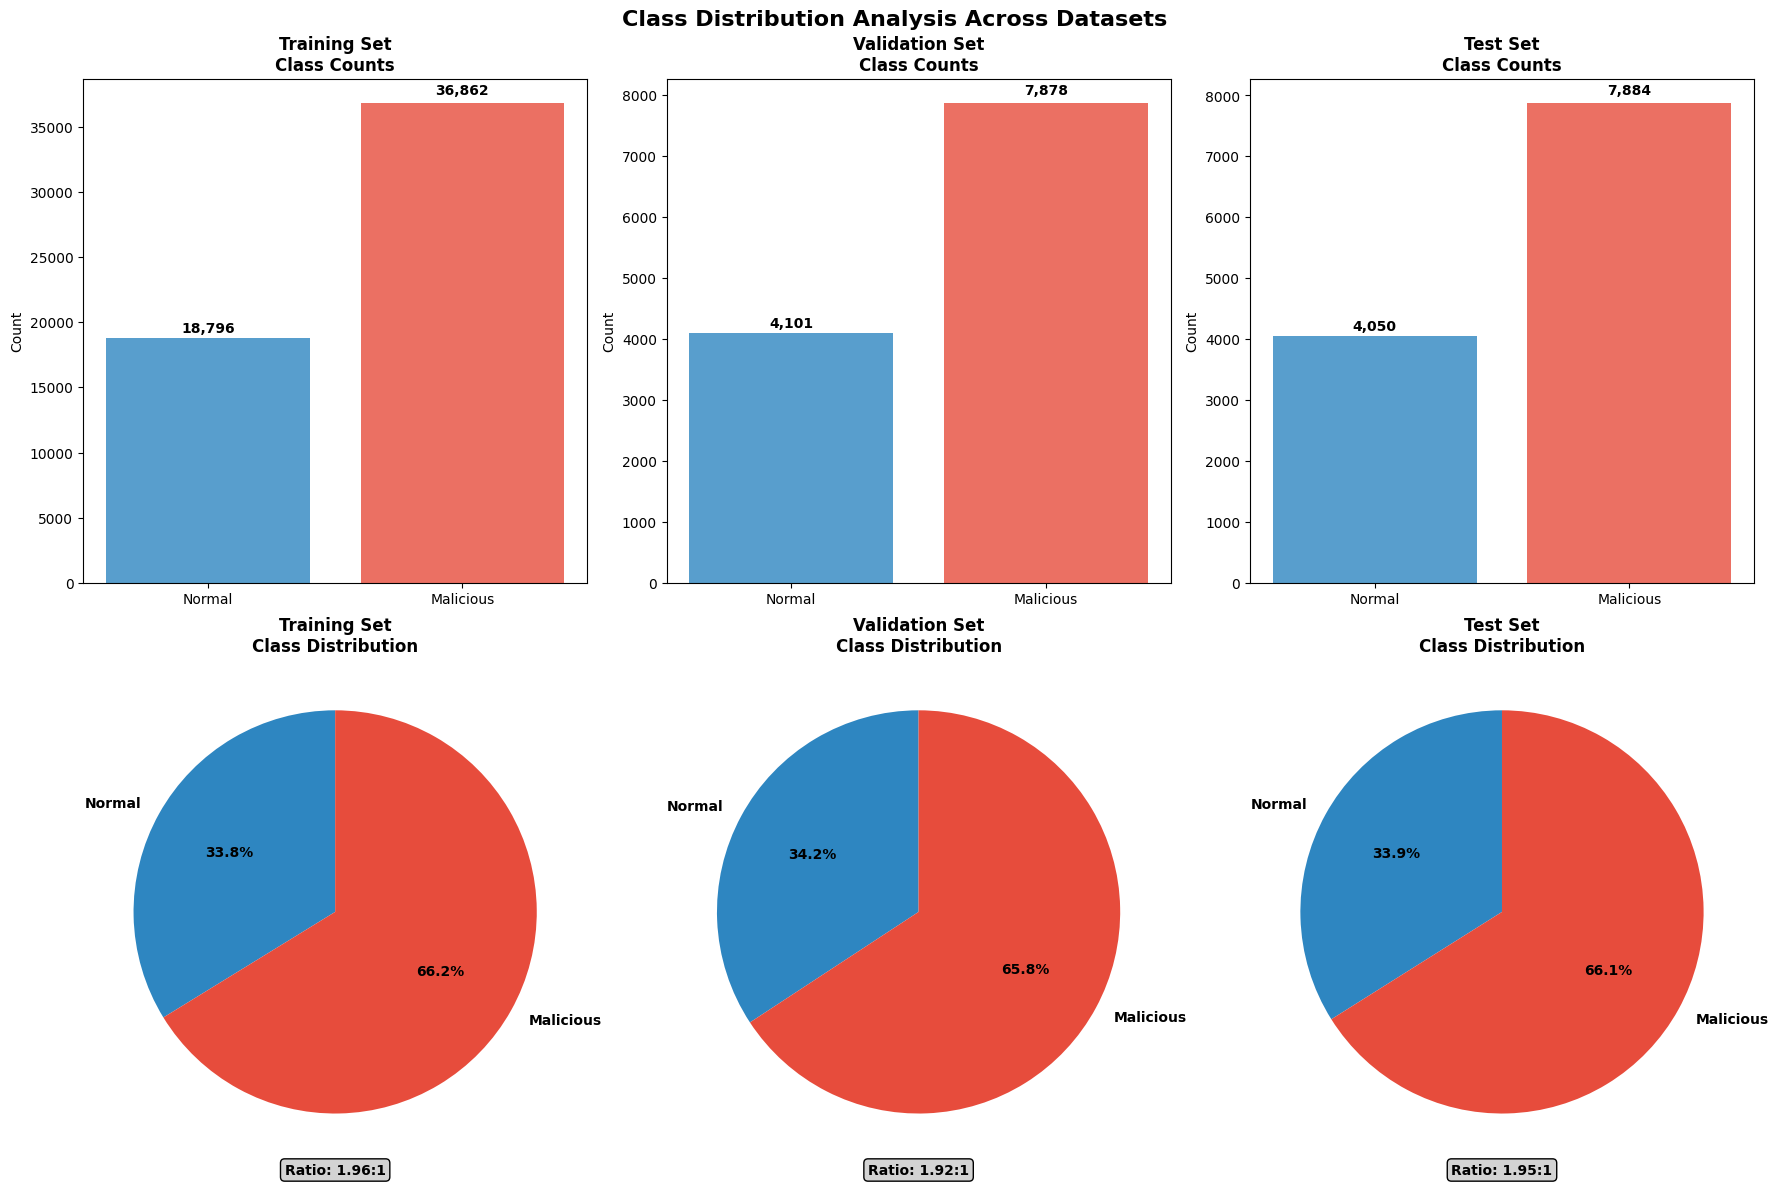


 DETAILED CLASS STATISTICS:

Training Set:
  Normal (0): 18,796 (33.8%)
  Malicious (1): 36,862 (66.2%)
  Balance Ratio: 1.96:1
  Total: 55,658

Validation Set:
  Normal (0): 4,101 (34.2%)
  Malicious (1): 7,878 (65.8%)
  Balance Ratio: 1.92:1
  Total: 11,979

Test Set:
  Normal (0): 4,050 (33.9%)
  Malicious (1): 7,884 (66.1%)
  Balance Ratio: 1.95:1
  Total: 11,934


In [27]:
# 1. CLASS DISTRIBUTION ANALYSIS
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Class Distribution Analysis Across Datasets', fontsize=16, fontweight='bold')

# Bar plots for counts
datasets = [('Training', df_train), ('Validation', df_val), ('Test', df_test)]
colors = ['skyblue', 'lightcoral', 'lightgreen']

for i, (name, df) in enumerate(datasets):
    # Count plot
    ax = axes[0, i]
    counts = df['label'].value_counts().sort_index()
    bars = ax.bar(['Normal', 'Malicious'], counts.values, color=['#2E86C1', '#E74C3C'], alpha=0.8)
    ax.set_title(f'{name} Set\nClass Counts', fontweight='bold')
    ax.set_ylabel('Count')
    
    # Add value labels on bars
    for bar, count in zip(bars, counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01, 
                f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    # Pie chart
    ax = axes[1, i]
    labels = ['Normal', 'Malicious']
    sizes = counts.values
    colors_pie = ['#2E86C1', '#E74C3C']
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%', 
                                      startangle=90, textprops={'fontweight': 'bold'})
    ax.set_title(f'{name} Set\nClass Distribution', fontweight='bold')
    
    # Calculate and display ratio
    ratio = counts.max() / counts.min()
    ax.text(0, -1.3, f'Ratio: {ratio:.2f}:1', ha='center', fontweight='bold', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n DETAILED CLASS STATISTICS:")
print("=" * 40)
for name, df in datasets:
    counts = df['label'].value_counts().sort_index()
    total = len(df)
    ratio = counts.max() / counts.min()
    
    print(f"\n{name} Set:")
    print(f"  Normal (0): {counts[0]:,} ({counts[0]/total*100:.1f}%)")
    print(f"  Malicious (1): {counts[1]:,} ({counts[1]/total*100:.1f}%)")
    print(f"  Balance Ratio: {ratio:.2f}:1")
    print(f"  Total: {total:,}")


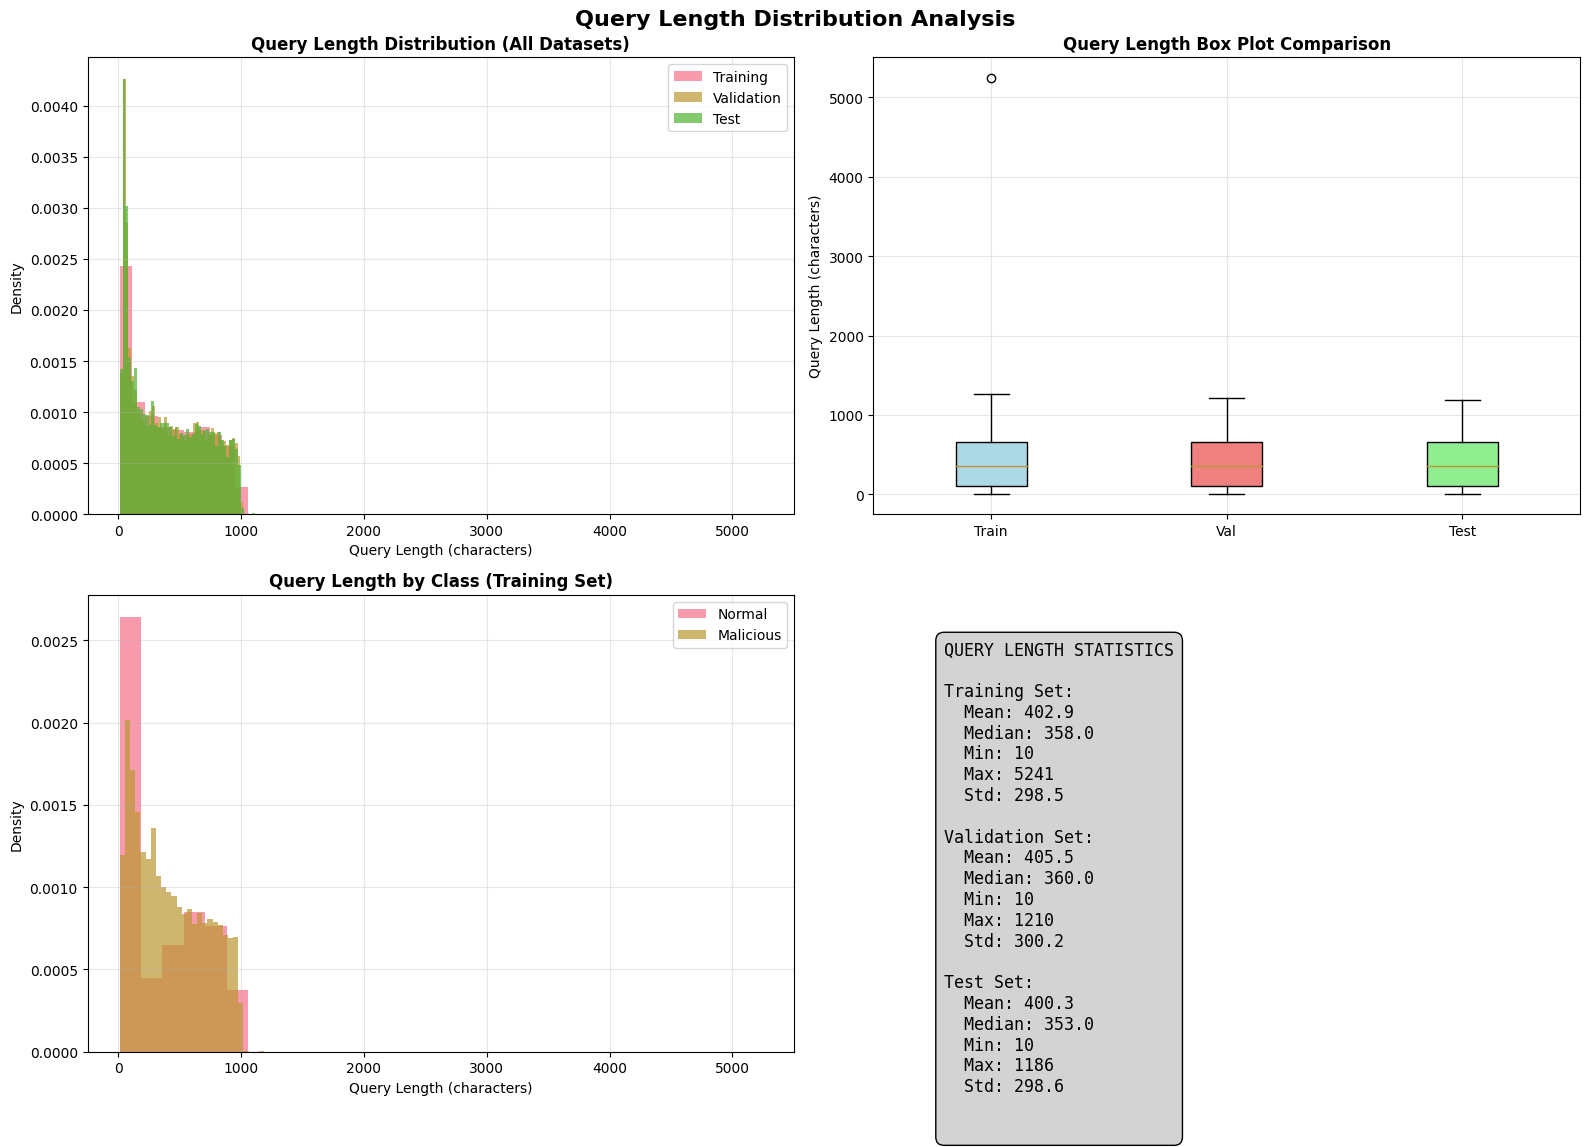


 QUERY LENGTH PERCENTILE ANALYSIS:
Percentile | Length
--------------------
       1th |     21
       5th |     38
      10th |     50
      25th |    111
      50th |    358
      75th |    658
      90th |    846
      95th |    919
      99th |    981


In [26]:
# 2. QUERY LENGTH ANALYSIS
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Query Length Distribution Analysis', fontsize=16, fontweight='bold')

# Combined histogram
ax = axes[0, 0]
for i, (name, df) in enumerate(datasets):
    ax.hist(df['query_length'], bins=50, alpha=0.7, label=name, density=True)
ax.set_title('Query Length Distribution (All Datasets)', fontweight='bold')
ax.set_xlabel('Query Length (characters)')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

# Box plot comparison
ax = axes[0, 1]
data_for_box = [df_train['query_length'], df_val['query_length'], df_test['query_length']]
box_plot = ax.boxplot(data_for_box, labels=['Train', 'Val', 'Test'], patch_artist=True)
colors = ['lightblue', 'lightcoral', 'lightgreen']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
ax.set_title('Query Length Box Plot Comparison', fontweight='bold')
ax.set_ylabel('Query Length (characters)')
ax.grid(True, alpha=0.3)

# Query length by class (Training set)
ax = axes[1, 0]
for class_label, class_name in [(0, 'Normal'), (1, 'Malicious')]:
    data = df_train[df_train['label'] == class_label]['query_length']
    ax.hist(data, bins=30, alpha=0.7, label=class_name, density=True)
ax.set_title('Query Length by Class (Training Set)', fontweight='bold')
ax.set_xlabel('Query Length (characters)')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

# Statistics summary
ax = axes[1, 1]
ax.axis('off')
stats_text = "QUERY LENGTH STATISTICS\n\n"
for name, df in datasets:
    lengths = df['query_length']
    stats_text += f"{name} Set:\n"
    stats_text += f"  Mean: {lengths.mean():.1f}\n"
    stats_text += f"  Median: {lengths.median():.1f}\n"
    stats_text += f"  Min: {lengths.min()}\n"
    stats_text += f"  Max: {lengths.max()}\n"
    stats_text += f"  Std: {lengths.std():.1f}\n\n"

ax.text(0.1, 0.9, stats_text, transform=ax.transAxes, fontsize=12, 
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray"))

plt.tight_layout()
plt.show()

# Print percentile analysis
print("\n QUERY LENGTH PERCENTILE ANALYSIS:")
print("=" * 45)
combined_lengths = pd.concat([df_train['query_length'], df_val['query_length'], df_test['query_length']])
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print("Percentile | Length")
print("-" * 20)
for p in percentiles:
    length = np.percentile(combined_lengths, p)
    print(f"{p:8}th | {length:6.0f}")



 FEATURE ANALYSIS (53 features)


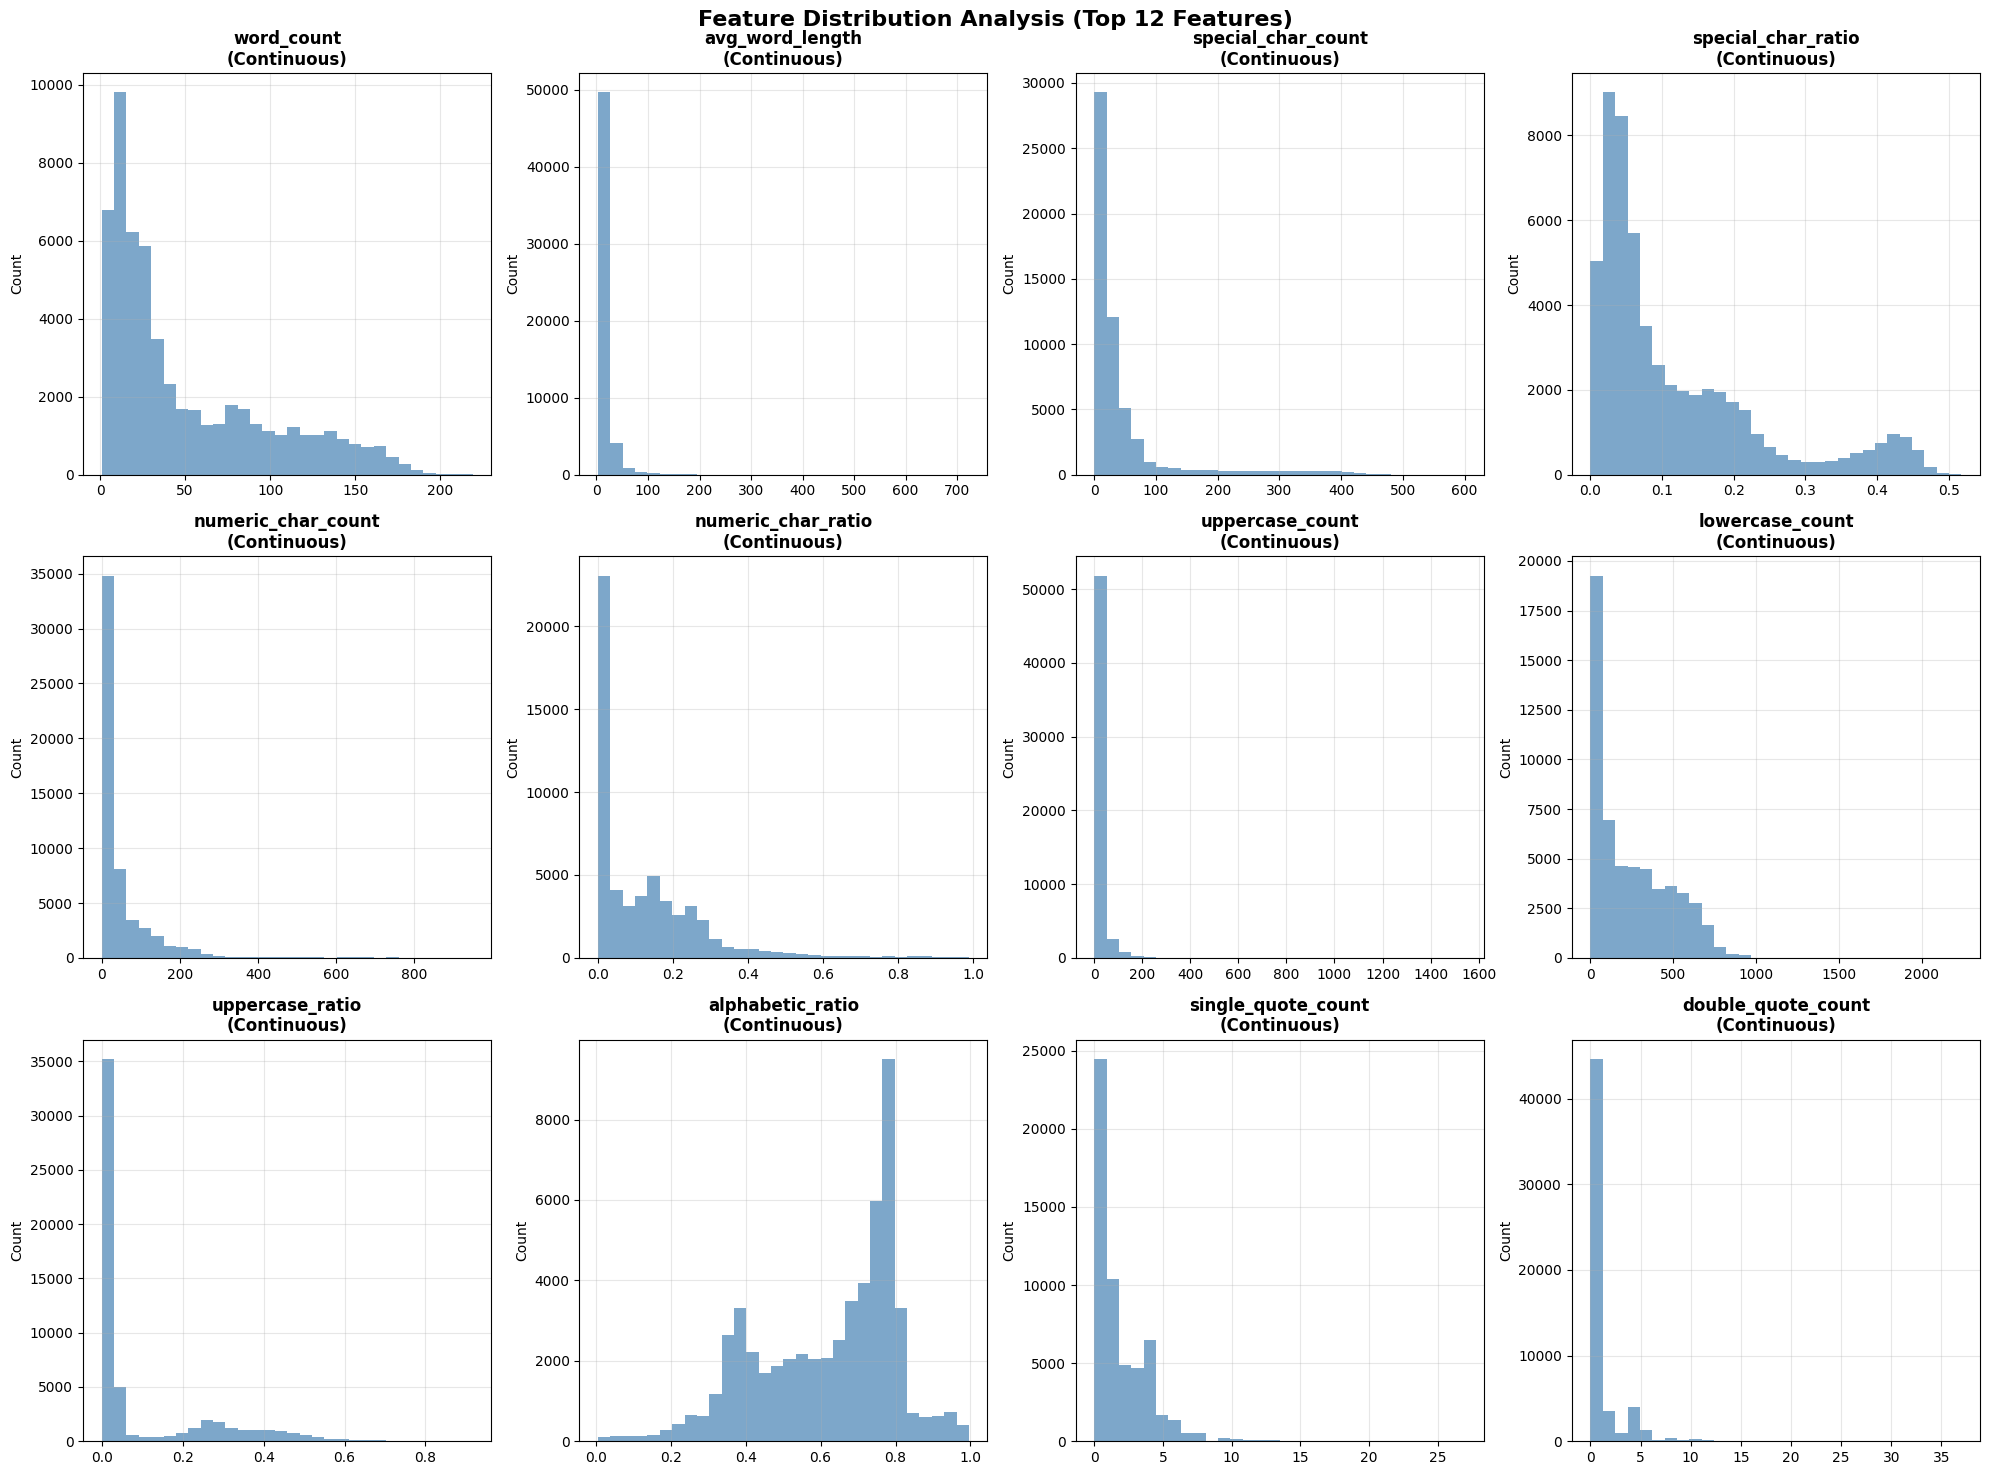

In [29]:
# 3. FEATURE ANALYSIS (for features other than query and label)
feature_cols = [col for col in df_train.columns if col not in ['query', 'label', 'query_length']]

if len(feature_cols) > 0:
    print(f"\n FEATURE ANALYSIS ({len(feature_cols)} features)")
    
    # Select top features for visualization
    top_features = feature_cols[:12] if len(feature_cols) > 12 else feature_cols
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle('Feature Distribution Analysis (Top 12 Features)', fontsize=16, fontweight='bold')
    axes = axes.flatten()
    
    for i, feature in enumerate(top_features):
        ax = axes[i]
        
        # Check if feature is binary or continuous
        unique_vals = df_train[feature].nunique()
        
        if unique_vals <= 2:
            # Binary feature - bar plot
            counts = df_train[feature].value_counts().sort_index()
            ax.bar(range(len(counts)), counts.values, color='steelblue', alpha=0.7)
            ax.set_xticks(range(len(counts)))
            ax.set_xticklabels(counts.index)
            ax.set_title(f'{feature}\n(Binary)', fontweight='bold')
        else:
            # Continuous feature - histogram
            ax.hist(df_train[feature], bins=30, color='steelblue', alpha=0.7)
            ax.set_title(f'{feature}\n(Continuous)', fontweight='bold')
        
        ax.set_ylabel('Count')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for j in range(len(top_features), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("\n No additional features found for visualization")


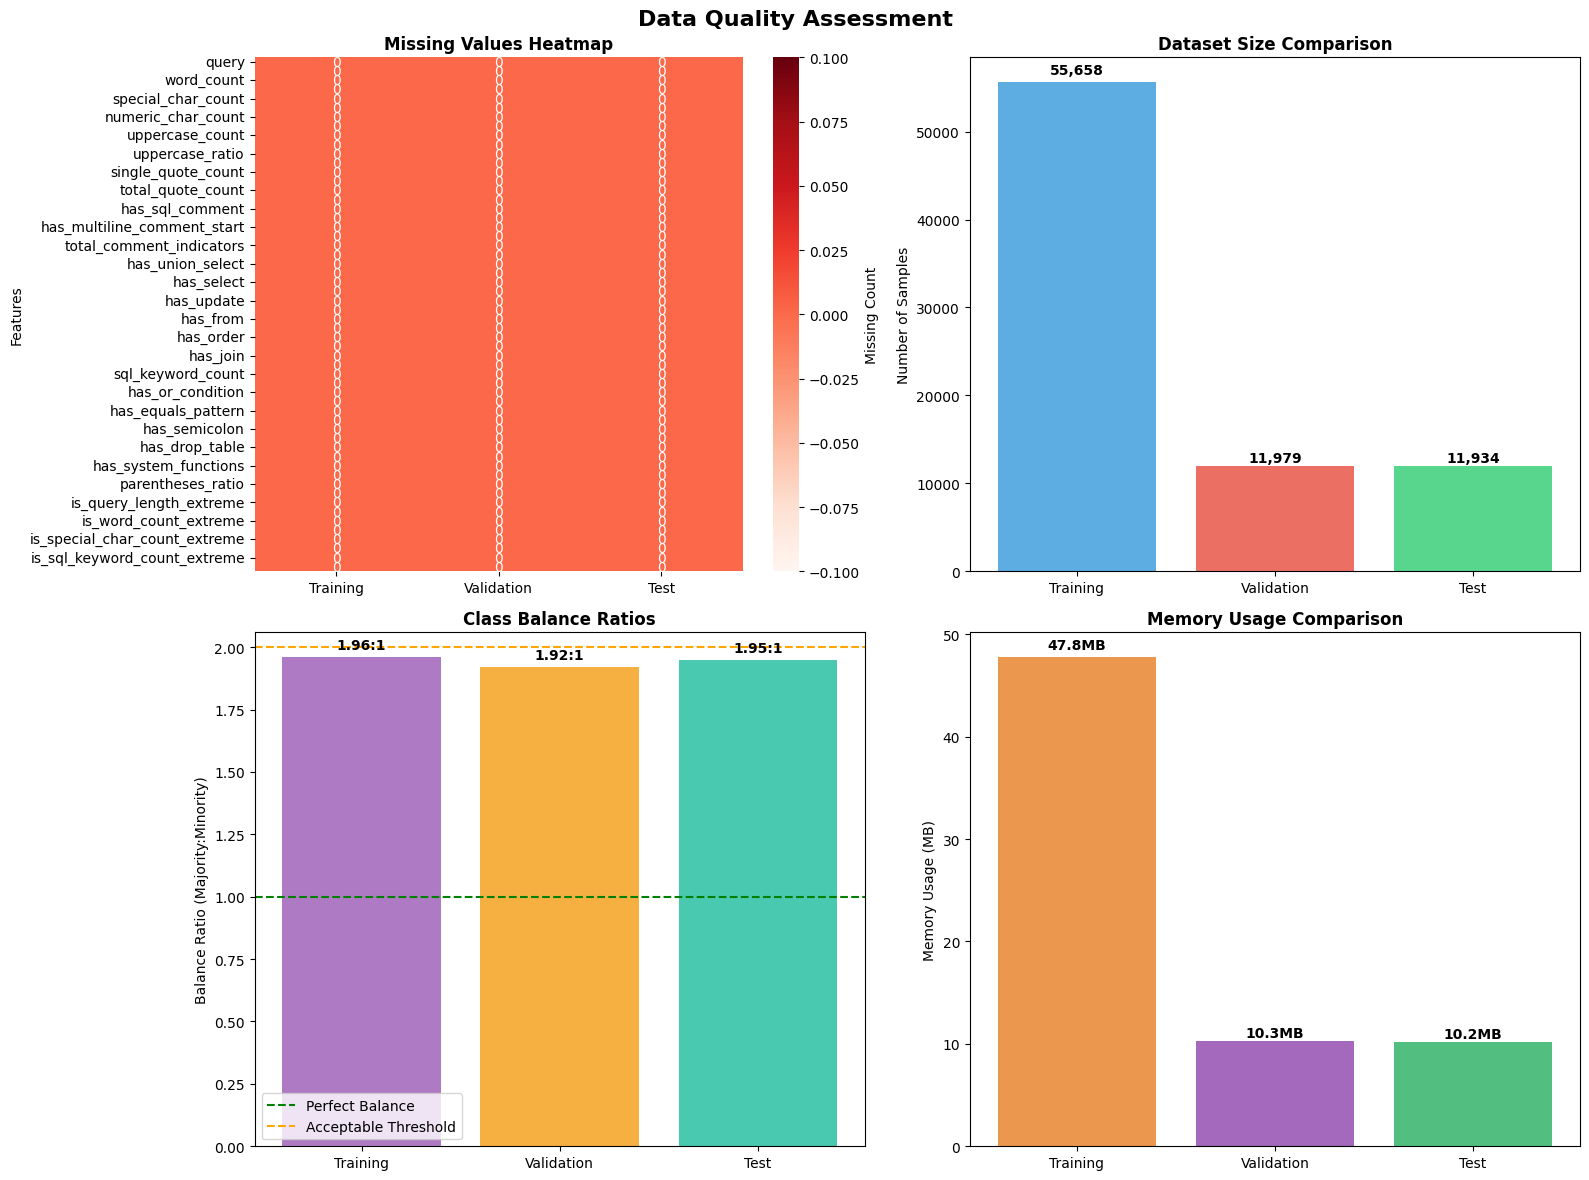

In [24]:
# 4. DATA QUALITY ASSESSMENT VISUALIZATIONS
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Data Quality Assessment', fontsize=16, fontweight='bold')

# Missing values heatmap
ax = axes[0, 0]
missing_data = pd.DataFrame({
    'Training': df_train.isnull().sum(),
    'Validation': df_val.isnull().sum(),
    'Test': df_test.isnull().sum()
})
sns.heatmap(missing_data, annot=True, fmt='d', cmap='Reds', ax=ax, cbar_kws={'label': 'Missing Count'})
ax.set_title('Missing Values Heatmap', fontweight='bold')
ax.set_ylabel('Features')

# Dataset size comparison
ax = axes[0, 1]
sizes = [len(df_train), len(df_val), len(df_test)]
colors = ['#3498DB', '#E74C3C', '#2ECC71']
bars = ax.bar(['Training', 'Validation', 'Test'], sizes, color=colors, alpha=0.8)
ax.set_title('Dataset Size Comparison', fontweight='bold')
ax.set_ylabel('Number of Samples')
for bar, size in zip(bars, sizes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01, 
            f'{size:,}', ha='center', va='bottom', fontweight='bold')

# Class balance across datasets
ax = axes[1, 0]
balance_ratios = []
dataset_names = []
for name, df in datasets:
    counts = df['label'].value_counts().sort_index()
    ratio = counts.max() / counts.min()
    balance_ratios.append(ratio)
    dataset_names.append(name)

bars = ax.bar(dataset_names, balance_ratios, color=['#9B59B6', '#F39C12', '#1ABC9C'], alpha=0.8)
ax.axhline(y=1.0, color='green', linestyle='--', label='Perfect Balance')
ax.axhline(y=2.0, color='orange', linestyle='--', label='Acceptable Threshold')
ax.set_title('Class Balance Ratios', fontweight='bold')
ax.set_ylabel('Balance Ratio (Majority:Minority)')
ax.legend()
for bar, ratio in zip(bars, balance_ratios):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{ratio:.2f}:1', ha='center', va='bottom', fontweight='bold')

# Memory usage comparison
ax = axes[1, 1]
memory_usage = [
    df_train.memory_usage(deep=True).sum() / 1024**2,
    df_val.memory_usage(deep=True).sum() / 1024**2,
    df_test.memory_usage(deep=True).sum() / 1024**2
]
bars = ax.bar(['Training', 'Validation', 'Test'], memory_usage, 
              color=['#E67E22', '#8E44AD', '#27AE60'], alpha=0.8)
ax.set_title('Memory Usage Comparison', fontweight='bold')
ax.set_ylabel('Memory Usage (MB)')
for bar, usage in zip(bars, memory_usage):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01, 
            f'{usage:.1f}MB', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
